In [2]:
#%pip install torch
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import random

# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel
block_size = 15 # what is the maximum context length for predictions
max_iters = 5000
eval_interval = 50
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
eval_iters = 100
n_embd = 400
n_head = 7
n_layer = 9
dropout = 0.2
temperature = 1.2

cuda


In [3]:
import os
def save(model,file_name='modelPokemonStats.pth'):
    model_folder_path = './model'
    if not os.path.exists(model_folder_path):
        os.makedirs(model_folder_path)
    file_name = os.path.join(model_folder_path, file_name)
    torch.save(model.state_dict(),file_name)
    
def load(file_name='modelPokemonStats.pth'):
    model_folder_path = './model'
    
    file_name = os.path.join(model_folder_path, file_name)
    return file_name
    #torch.save(self.state_dict(),file_name)
    


In [4]:
torch.manual_seed(1337)

with open('PokemonStatsFile.txt', 'r', encoding='utf-8', errors='ignore') as f:
    lines = f.readlines()
    random.shuffle(lines)
f.close()

open('PokemonStatsFile.txt', 'w').writelines(lines)
with open('PokemonStatsFile.txt', 'r', encoding='utf-8', errors='ignore') as f:
    text = f.read().replace("\n","")
#print(text)
# here are all the unique characters that occur in this text
chars = sorted(list(set(text.split(","))))#+sorted(list(set(text)))

Alphabet = chars
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
print(stoi)
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ' '.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
print(stoi['Fairy'])
# Train and test splits
data = torch.tensor(encode(text.split(",")), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]


print(len(train_data))

{'': 0, '0': 1, '1': 2, '10': 3, '100': 4, '104': 5, '105': 6, '106': 7, '107': 8, '108': 9, '112': 10, '114': 11, '115': 12, '116': 13, '118': 14, '12': 15, '120': 16, '123': 17, '124': 18, '125': 19, '126': 20, '128': 21, '130': 22, '131': 23, '132': 24, '133': 25, '136': 26, '138': 27, '14': 28, '140': 29, '142': 30, '144': 31, '148': 32, '149': 33, '150': 34, '152': 35, '156': 36, '158': 37, '16': 38, '160': 39, '163': 40, '164': 41, '168': 42, '170': 43, '171': 44, '172': 45, '174': 46, '175': 47, '176': 48, '177': 49, '180': 50, '184': 51, '186': 52, '187': 53, '188': 54, '190': 55, '191': 56, '192': 57, '196': 58, '198': 59, '2': 60, '20': 61, '200': 62, '204': 63, '208': 64, '210': 65, '211': 66, '212': 67, '216': 68, '220': 69, '224': 70, '228': 71, '230': 72, '232': 73, '234': 74, '236': 75, '239': 76, '24': 77, '240': 78, '242': 79, '244': 80, '245': 81, '248': 82, '251': 83, '252': 84, '28': 85, '3': 86, '30': 87, '31': 88, '32': 89, '36': 90, '39': 91, '4': 92, '40': 93, '

In [5]:
print(train_data)

tensor([476, 475, 596,  ..., 126, 479, 513])


In [6]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    #print(x,len(y))
    x, y = x.to(device), y.to(device)

    return x, y

@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        #wei = torch.exp(wei/temperature)/(sum(torch.exp(wei/temperature)))
        #print((wei))
        #print(sum(torch.exp(wei/temperature)))
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        
        #print(np.exp(wei/temp))
        #newWei = np.exp(wei/temp)/sum(np.exp(wei/temp))
        #print(newWei)
        #wei = torch.tensor(wei, dtype=torch.long,device='cuda')
        
        
        wei = F.softmax(wei.to(device), dim=-1) # (B, T, T)
        
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        #print(B,T)

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            #print(idx,"DIFF",idx_cond)
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1]#, :] # becomes (B, C)
            
            # apply softmax to get probabilities
            #logits = torch.tensor(logits, dtype=torch.long,device='cuda')
            probs = torch.exp(logits[-1]/temperature)/sum(torch.exp(logits[-1]/temperature))
            #print(torch.exp(logits[-1]/temperature))
            #probs = F.softmax((logits.to(device)), dim=-1) # (B, C)
            probs = probs.reshape(1,len(chars))
            #print(probs)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx
    def generateAttentionMap():
        ## Use Heads 'forward' function to return the out and map it to the rest of the word
        ## hopefully this will show us what the attention head focuses on and maybe it could be
        ## manipulated to give certain outputs
        pass




In [25]:
model = GPTLanguageModel()
device = 'cuda'
model.load_state_dict(torch.load('./model/modelPokemonStats.pth'))
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#print(list(model.signature.keys()))

17.895533 M parameters


In [31]:
for iter in range(max_iters):
   
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss(model)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        save(model)

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 0.7019, val loss 1.7930
step 50: train loss 0.6937, val loss 1.7918
step 100: train loss 0.6954, val loss 1.7983
step 150: train loss 0.6973, val loss 1.8012
step 200: train loss 0.6930, val loss 1.8219
step 250: train loss 0.6864, val loss 1.8300
step 300: train loss 0.6923, val loss 1.8215
step 350: train loss 0.6926, val loss 1.8145
step 400: train loss 0.6856, val loss 1.8488
step 450: train loss 0.6824, val loss 1.8325
step 500: train loss 0.6843, val loss 1.8344
step 550: train loss 0.6828, val loss 1.8419
step 600: train loss 0.6830, val loss 1.8643
step 650: train loss 0.6844, val loss 1.8326
step 700: train loss 0.6776, val loss 1.8669
step 750: train loss 0.6791, val loss 1.8494
step 800: train loss 0.6769, val loss 1.8722
step 850: train loss 0.6760, val loss 1.8839
step 900: train loss 0.6711, val loss 1.8874
step 950: train loss 0.6636, val loss 1.8543
step 1000: train loss 0.6706, val loss 1.8769
step 1050: train loss 0.6682, val loss 1.9078
step 1100: 

In [32]:

# import modules
import pandas as pd
 
# read the data from the csv
device = 'cuda'
alphabet = Alphabet

inputText = ["Fairy","Fire","Choice Band"]
multiplier = 1
temperature = 1.2
with open('PokemonStatsFile.txt', 'r', encoding='utf-8', errors='ignore') as f:
    text = f.read().replace("\n","")

# here are all the unique characters that occur in this text
chars = sorted(list(set(text.split(","))))#+sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoiT = { ch:i for i,ch in enumerate(chars) }
itosT = { i:ch for i,ch in enumerate(chars) }
encoder = lambda s: [stoiT[c] for c in s] # encoder: take a string, output a list of integers
decoder = lambda l: ','.join([itosT[i] for i in l])
outputArr = []
#for i in range(0,1):

dataT = torch.tensor(encoder(inputText), dtype=torch.long,device='cuda')
#dataT = dataT.detach().numpy()

print(list(dataT))
temp = []
for i in range(0,len(list(dataT))):
    temp.append(dataT[i])
#print(temp)
dataT = torch.tensor(temp, dtype=torch.long,device='cuda')
#print(dataT)
context = dataT.to(device)#torch.tensor(dataInput)


output = (decoder(model.generate(context.reshape(1,len(context)), max_new_tokens=block_size-len(inputText))[0].tolist()))
outputArr.append(output)
print(output)
#Pokemon Structure = Type1, Type2, Item, Nature, HP, Atk, Sp. Atk, Def, Sp. Def, Speed, Ability, Move1, Move2, Move3, Move4.
#To fix any issues, generate the incorrect token again using all the previous tokens that were correctly placed.
#Make sure the IVs add up to the correct amount, generate until the IVs are legal.

[tensor(294, device='cuda:0'), tensor(301, device='cuda:0'), tensor(208, device='cuda:0')]
Fairy,Fire,Choice Band,Adamant,52,252,4,0,4,196,Multiscale,Rock Slide,Hurricane,Thunder Punch,Dual Wingbeat


In [33]:
def GenerateRandomPokemon():
    Types = ['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 
            'Ghost', 'Grass', 'Ground', 'Ice', 'None', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water']

    Items = ['Protective Pads', 'Bright Powder', 'Lansat Berry', 'Absorb Bulb', 'Iron Ball', 'Occa Berry', 
    'Scope Lens', 'Flame Orb', 'Weakness Policy', 'Quick Claw', 'Spell Tag', 'Sharp Beak', 'Grassy Seed', 
    'Griseous Orb', 'Rocky Helmet', 'Muscle Band', 'White Herb', 'Metal Coat', 'Rawst Berry', 'Dragon Fang', 
    'Colbur Berry', 'Choice Specs', 'Liechi Berry', 'Light Clay', 'Toxic Orb', 'Adrenaline Orb', 'Red Card', 
    'Pixie Plate', 'Power Anklet', 'Wiki Berry', 'Kee Berry', 'Rindo Berry', 'Power Herb', 'Zoom Lens', 
    'Blunder Policy', 'Figy Berry', 'Room Service', 'Charcoal', 'Coba Berry', 'Eject Pack', 'Poison Barb', 
    'Rusted Shield', 'Chesto Berry', 'Heavy-Duty Boots', 'Eviolite', 'Lagging Tail', 'Payapa Berry', 'Sea Incense', 
    'Sitrus Berry', 'Black Belt', 'Full Incense', 'Silk Scarf', 'Adamant Orb', 'Heat Rock', 'Leek', 'Normal Gem', 
    'Binding Band', 'Mystic Water', 'Wacan Berry', 'Psychic Seed', 'Rusted Sword', 'Black Sludge', 'Lum Berry', 
    'Iapapa Berry', 'Metronome', 'Chople Berry', 'Custap Berry', 'Never-Melt Ice', 'Focus Sash', 'Thick Club', 
    'Shuca Berry', 'Razor Claw', 'Charti Berry', 'Utility Umbrella', 'Assault Vest', 'Damp Rock', 'Life Orb', 
    'Haban Berry', 'Light Ball', 'Misty Seed', 'Babiri Berry', 'Starf Berry', 'Magnet', 'Power Lens', 'Expert Belt', 
    'Mental Herb', 'Miracle Seed', 'Twisted Spoon', 'Safety Goggles', 'Throat Spray', 'Smooth Rock', 'Leftovers', 
    'Eject Button', 'Kasib Berry', 'Cell Battery', 'Rose Incense', 'Wise Glasses', 'Wave Incense', 'Passho Berry', 
    'Choice Scarf', 'Electric Seed', 'Choice Band', 'Roseli Berry', 'Snowball', 'Wide Lens', 'Mago Berry', 'Focus Band', 
    'Lustrous Orb', 'Black Glasses', 'Aguav Berry', 'Air Balloon', 'Salac Berry', 'Yache Berry']
    
    Moves = ["Absorb","Accelerock","Acid","Acid Armor","Acid Spray","Acrobatics","Acupressure","Aerial Ace","Aeroblast","After You","Agility","Air Cutter","Air Slash","Ally Switch","Amnesia","Anchor Shot","Ancient Power","Apple Acid","Aqua Jet","Aqua Ring","Aqua Tail","Arm Thrust","Aromatherapy","Aromatic Mist","Assist","Assurance","Astonish","Astral Barrage","Attack Order","Attract","Aura Sphere","Aura Wheel","Aurora Beam","Aurora Veil","Autotomize","Avalanche","Baby Doll Eyes","Baddy Bad","Baneful Bunker","Barrage","Barrier","Baton Pass","Beak Blast","Beat Up","Behemoth Bash","Behemoth Blade","Belch","Belly Drum","Bestow","Bide","Bind","Bite","Blast Burn","Blaze Kick","Blizzard","Block","Blue Flare","Body Press","Body Slam","Bolt Beak","Bolt Strike","Bone Club","Bone Rush","Bonemerang","Boomburst","Bounce","Bouncy Bubble","Branch Poke","Brave Bird","Breaking Swipe","Brick Break","Brine","Brutal Swing","Bubble","Bubble Beam","Bug Bite","Bug Buzz","Bulk Up","Bulldoze","Bullet Punch","Bullet Seed","Burn Up","Burning Jealousy","Buzzy Buzz","Calm Mind","Camouflage","Captivate","Catastropika","Celebrate","Charge","Charge Beam","Charm","Chatter","Chip Away","Circle Throw","Clamp","Clanging Scales","Clangorous Soul","Clangorous Soulblaze","Clear Smog","Close Combat","Coaching","Coil","Comet Punch","Confide","Confuse Ray","Confusion","Constrict","Conversion","Conversion 2","Copycat","Core Enforcer","Corrosive Gas","Cosmic Power","Cotton Guard","Cotton Spore","Counter","Court Change","Covet","Crabhammer","Crafty Shield","Cross Chop","Cross Poison","Crunch","Crush Claw","Crush Grip","Curse","Cut","Dark Pulse","Dark Void","Darkest Lariat","Dazzling Gleam","Decorate","Defend Order","Defense Curl","Defog","Destiny Bond","Detect","Diamond Storm","Dig","Disable","Disarming Voice","Discharge","Dive","Dizzy Punch","Doom Desire","Double Edge","Double Hit","Double Iron Bash","Double Kick","Double Slap","Double Team","Draco Meteor","Dragon Ascent","Dragon Breath","Dragon Claw","Dragon Dance","Dragon Darts","Dragon Energy","Dragon Hammer","Dragon Pulse","Dragon Rage","Dragon Rush","Dragon Tail","Drain Punch","Draining Kiss","Dream Eater","Drill Peck","Drill Run","Drum Beating","Dual Chop","Dual Wingbeat","Dynamax Cannon","Dynamic Punch","Earth Power","Earthquake","Echoed Voice","Eerie Impulse","Eerie Spell","Egg Bomb","Electric Terrain","Electrify","Electro Ball","Electroweb","Embargo","Ember","Encore","Endeavor","Endure","Energy Ball","Entrainment","Eruption","Eternabeam","Expanding Force","Explosion","Extrasensory","Extreme Evoboost","Extreme Speed","Facade","Fairy Lock","Fairy Wind","Fake Out","Fake Tears","False Surrender","False Swipe","Feather Dance","Feint","Feint Attack","Fell Stinger","Fiery Dance","Fiery Wrath","Final Gambit","Fire Blast","Fire Fang","Fire Lash","Fire Pledge","Fire Punch","Fire Spin","First Impression","Fishious Rend","Fissure","Flail","Flame Burst","Flame Charge","Flame Wheel","Flamethrower","Flare Blitz","Flash","Flash Cannon","Flatter","Fleur Cannon","Fling","Flip Turn","Floaty Fall","Floral Healing","Flower Shield","Fly","Flying Press","Focus Blast","Focus Energy","Focus Punch","Follow Me","Force Palm","Foresight","Forest'S Curse","Foul Play","Freeze Dry","Freeze Shock","Freezing Glare","Freezy Frost","Frenzy Plant","Frost Breath","Frustration","Fury Attack","Fury Cutter","Fury Swipes","Fusion Bolt","Fusion Flare","Future Sight","Gastro Acid","Gear Grind","Gear Up","Genesis Supernova","Geomancy","Giga Drain","Giga Impact","Glacial Lance","Glaciate","Glare","Glitzy Glow","Grass Knot","Grass Pledge","Grass Whistle","Grassy Glide","Grassy Terrain","Grav Apple","Gravity","Growl","Growth","Grudge","Guard Split","Guard Swap","Guardian Of Alola","Guillotine","Gunk Shot","Gust","Gyro Ball","Hail","Hammer Arm","Happy Hour","Harden","Haze","Head Charge","Head Smash","Headbutt","Heal Bell","Heal Block","Heal Order","Heal Pulse","Healing Wish","Heart Stamp","Heart Swap","Heat Crash","Heat Wave","Heavy Slam","Helping Hand","Hex","Hidden Power","High Horsepower","High Jump Kick","Hold Back","Hold Hands","Hone Claws","Horn Attack","Horn Drill","Horn Leech","Howl","Hurricane","Hydro Cannon","Hydro Pump","Hyper Beam","Hyper Fang","Hyper Voice","Hyperspace Fury","Hyperspace Hole","Hypnosis","Ice Ball","Ice Beam","Ice Burn","Ice Fang","Ice Hammer","Ice Punch","Ice Shard","Icicle Crash","Icicle Spear","Icy Wind","Imprison","Incinerate","Inferno","Infestation","Ingrain","Instruct","Ion Deluge","Iron Defense","Iron Head","Iron Tail","Jaw Lock","Judgment","Jump Kick","Jungle Healing","Karate Chop","Kinesis","King'S Shield","Knock Off","Land'S Wrath","Laser Focus","Lash Out","Last Resort","Lava Plume","Leaf Blade","Leaf Storm","Leaf Tornado","Leafage","Leech Life","Leech Seed","Leer","Lick","Life Dew","Light Of Ruin","Light Screen","Light That Burns The Sky","Liquidation","Lock On","Lovely Kiss","Low Kick","Low Sweep","Lucky Chant","Lunar Dance","Lunge","Luster Purge","Mach Punch","Magic Coat","Magic Powder","Magic Room","Magical Leaf","Magma Storm","Magnet Bomb","Magnet Rise","Magnetic Flux","Magnitude","Malicious Moonsault","Mat Block","Max Airstream","Max Darkness","Max Flare","Max Flutterby","Max Geyser","Max Guard","Max Hailstorm","Max Knuckle","Max Lightning","Max Mindstorm","Max Ooze","Max Overgrowth","Max Phantasm","Max Quake","Max Rockfall","Max Starfall","Max Steelspike","Max Strike","Max Wyrmwind","Me First","Mean Look","Meditate","Mega Drain","Mega Kick","Mega Punch","Megahorn","Memento","Menacing Moonraze Maelstrom","Metal Burst","Metal Claw","Metal Sound","Meteor Assault","Meteor Beam","Meteor Mash","Metronome","Milk Drink","Mimic","Mind Blown","Mind Reader","Minimize","Miracle Eye","Mirror Coat","Mirror Move","Mirror Shot","Mist","Mist Ball","Misty Explosion","Misty Terrain","Moonblast","Moongeist Beam","Moonlight","Morning Sun","Mud Bomb","Mud Shot","Mud Slap","Mud Sport","Muddy Water","Multi Attack","Mystical Fire","Nasty Plot","Natural Gift","Nature Power","Nature'S Madness","Needle Arm","Night Daze","Night Shade","Night Slash","Nightmare","No Retreat","Noble Roar","Nuzzle","Oblivion Wing","Obstruct","Oceanic Operetta","Octazooka","Octolock","Odor Sleuth","Ominous Wind","Origin Pulse","Outrage","Overdrive","Overheat","Pain Split","Parabolic Charge","Parting Shot","Pay Day","Payback","Peck","Perish Song","Petal Blizzard","Petal Dance","Phantom Force","Photon Geyser","Pika Papow","Pin Missile","Plasma Fists","Play Nice","Play Rough","Pluck","Poison Fang","Poison Gas","Poison Jab","Poison Powder","Poison Sting","Poison Tail","Pollen Puff","Poltergeist","Pound","Powder","Powder Snow","Power Gem","Power Split","Power Swap","Power Trick","Power Trip","Power Up Punch","Power Whip","Precipice Blades","Present","Prismatic Laser","Protect","Psybeam","Psych Up","Psychic","Psychic Fangs","Psychic Terrain","Psycho Boost","Psycho Cut","Psycho Shift","Psyshock","Psystrike","Psywave","Pulverizing Pancake","Punishment","Purify","Pursuit","Pyro Ball","Quash","Quick Attack","Quick Guard","Quiver Dance","Rage","Rage Powder","Rain Dance","Rapid Spin","Razor Leaf","Razor Shell","Razor Wind","Recover","Recycle","Reflect","Reflect Type","Refresh","Relic Song","Rest","Retaliate","Return","Revelation Dance","Revenge","Reversal","Rising Voltage","Roar","Roar Of Time","Rock Blast","Rock Climb","Rock Polish","Rock Slide","Rock Smash","Rock Throw","Rock Tomb","Rock Wrecker","Role Play","Rolling Kick","Rollout","Roost","Rototiller","Round","Sacred Fire","Sacred Sword","Safeguard","Sand Attack","Sand Tomb","Sandstorm","Sappy Seed","Scald","Scale Shot","Scary Face","Scorching Sands","Scratch","Screech","Searing Shot","Searing Sunraze Smash","Secret Power","Secret Sword","Seed Bomb","Seed Flare","Seismic Toss","Self Destruct","Shadow Ball","Shadow Bone","Shadow Claw","Shadow Force","Shadow Punch","Shadow Sneak","Sharpen","Sheer Cold","Shell Side Arm","Shell Smash","Shell Trap","Shift Gear","Shock Wave","Shore Up","Signal Beam","Silver Wind","Simple Beam","Sing","Sinister Arrow Raid","Sizzly Slide","Sketch","Skill Swap","Skitter Smack","Skull Bash","Sky Attack","Sky Drop","Sky Uppercut","Slack Off","Slam","Slash","Sleep Powder","Sleep Talk","Sludge","Sludge Bomb","Sludge Wave","Smack Down","Smart Strike","Smelling Salts","Smog","Smokescreen","Snap Trap","Snarl","Snatch","Snipe Shot","Snore","Soak","Soft Boiled","Solar Beam","Solar Blade","Sonic Boom","Soul Stealing 7 Star Strike","Spacial Rend","Spark","Sparkling Aria","Sparkly Swirl","Spectral Thief","Speed Swap","Spider Web","Spike Cannon","Spikes","Spiky Shield","Spirit Break","Spirit Shackle","Spit Up","Spite","Splash","Splintered Stormshards","Splishy Splash","Spore","Spotlight","Stealth Rock","Steam Eruption","Steamroller","Steel Beam","Steel Roller","Steel Wing","Sticky Web","Stockpile","Stoked Sparksurfer","Stomp","Stomping Tantrum","Stone Edge","Stored Power","Storm Throw","Strange Steam","Strength","Strength Sap","String Shot","Struggle","Struggle Bug","Stuff Cheeks","Stun Spore","Submission","Substitute","Sucker Punch","Sunny Day","Sunsteel Strike","Super Fang","Superpower","Supersonic","Surf","Surging Strikes","Swagger","Swallow","Sweet Kiss","Sweet Scent","Swift","Switcheroo","Swords Dance","Synchronoise","Synthesis","Tackle","Tail Glow","Tail Slap","Tail Whip","Tailwind","Take Down","Tar Shot","Taunt","Tearful Look","Teatime","Techno Blast","Teeter Dance","Telekinesis","Teleport","Terrain Pulse","Thief","Thousand Arrows","Thousand Waves","Thrash","Throat Chop","Thunder","Thunder Cage","Thunder Fang","Thunder Punch","Thunder Shock","Thunder Wave","Thunderbolt","Thunderous Kick","Tickle","Topsy Turvy","Torment","Toxic","Toxic Spikes","Toxic Thread","Transform","Tri Attack","Trick","Trick Or Treat","Trick Room","Triple Axel","Triple Kick","Trop Kick","Trump Card","Twineedle","Twister","U Turn","Uproar","V Create","Vacuum Wave","Veevee Volley","Venom Drench","Venoshock","Vine Whip","Vise Grip","Vital Throw","Volt Switch","Volt Tackle","Wake Up Slap","Water Gun","Water Pledge","Water Pulse","Water Shuriken","Water Sport","Water Spout","Waterfall","Weather Ball","Whirlpool","Whirlwind","Wicked Blow","Wide Guard","Wild Charge","Will O Wisp","Wing Attack","Wish","Withdraw","Wonder Room","Wood Hammer","Work Up","Worry Seed","Wrap","Wring Out","X Scissor","Yawn","Zap Cannon","Zen Headbutt","Zing Zap","Zippy Zap","G-Max Vine Lash","G-Max Wildfire","G-Max Cannonade","G-Max Befuddle","G-Max Volt Crash","G-Max Gold Rush","G-Max Chi Strike","G-Max Terror","G-Max Foam Burst","G-Max Resonance","G-Max Cuddle","G-Max Replenish","G-Max Malodor","G-Max Meltdown","G-Max Drum Solo","G-Max Fireball","G-Max Hydrosnipe","G-Max Wind Rage","G-Max Gravitas","G-Max Stonesurge","G-Max Volcalith","G-Max Tartness","G-Max Sweetness","G-Max Sandblast","G-Max Stun Shock","G-Max Centiferno","G-Max Smite","G-Max Snooze","G-Max Finale","G-Max Steelsurge","G-Max Depletion","G-Max One Blow","G-Max Rapid Flow"]
    
    # read the data from the csv
    device = 'cuda'
    alphabet = Alphabet
    Type1 = Types[random.randint(0,len(Types)-1)]
    
    Type2 = Types[random.randint(0,len(Types)-1)]
    while Type2 == Type1:
        Type2 = Types[random.randint(0,len(Types)-1)]
    Item = Items[random.randint(0,len(Items)-1)]
    inputText = [Type1,Type2]
    #print(inputText)
    
    with open('PokemonStatsFile.txt', 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read().replace("\n","")
    
    # here are all the unique characters that occur in this text
    chars = sorted(list(set(text.split(","))))#+sorted(list(set(text)))
    vocab_size = len(chars)
    # create a mapping from characters to integers
    stoiT = { ch:i for i,ch in enumerate(chars) }
    itosT = { i:ch for i,ch in enumerate(chars) }
    encoder = lambda s: [stoiT[c] for c in s] # encoder: take a string, output a list of integers
    decoder = lambda l: ','.join([itosT[i] for i in l])
    outputArr = []
    #for i in range(0,1):

    dataT = torch.tensor(encoder(inputText), dtype=torch.long,device='cuda')
    #dataT = dataT.detach().numpy()

    #print(list(dataT))
    temp = []
    for i in range(0,len(list(dataT))):
        temp.append(dataT[i])
    #print(temp)
    dataT = torch.tensor(temp, dtype=torch.long,device='cuda')
    #print(dataT)
    context = dataT.to(device)#torch.tensor(dataInput)


    output = (decoder(model.generate(context.reshape(1,len(context)), max_new_tokens=block_size-len(inputText))[0].tolist()))
    outputArr.append(output)
    print(output.split(","))
    return output.split(",")

In [34]:
def AutoCorrect(Pokemon):
    with open('PokemonStatsFile.txt', 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read().replace("\n","")
    
    # here are all the unique characters that occur in this text
    chars = sorted(list(set(text.split(","))))#+sorted(list(set(text)))
    stoiT = { ch:i for i,ch in enumerate(chars) }
    itosT = { i:ch for i,ch in enumerate(chars) }
    encoder = lambda s: [stoiT[c] for c in s] # encoder: take a string, output a list of integers
    decoder = lambda l: ','.join([itosT[i] for i in l])
    
    Types = ['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 
            'Ghost', 'Grass', 'Ground', 'Ice', 'None', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water']

    Items = ['Protective Pads', 'Bright Powder', 'Lansat Berry', 'Absorb Bulb', 'Iron Ball', 'Occa Berry', 
    'Scope Lens', 'Flame Orb', 'Weakness Policy', 'Quick Claw', 'Spell Tag', 'Sharp Beak', 'Grassy Seed', 
    'Griseous Orb', 'Rocky Helmet', 'Muscle Band', 'White Herb', 'Metal Coat', 'Rawst Berry', 'Dragon Fang', 
    'Colbur Berry', 'Choice Specs', 'Liechi Berry', 'Light Clay', 'Toxic Orb', 'Adrenaline Orb', 'Red Card', 
    'Pixie Plate', 'Power Anklet', 'Wiki Berry', 'Kee Berry', 'Rindo Berry', 'Power Herb', 'Zoom Lens', 
    'Blunder Policy', 'Figy Berry', 'Room Service', 'Charcoal', 'Coba Berry', 'Eject Pack', 'Poison Barb', 
    'Rusted Shield', 'Chesto Berry', 'Heavy-Duty Boots', 'Eviolite', 'Lagging Tail', 'Payapa Berry', 'Sea Incense', 
    'Sitrus Berry', 'Black Belt', 'Full Incense', 'Silk Scarf', 'Adamant Orb', 'Heat Rock', 'Leek', 'Normal Gem', 
    'Binding Band', 'Mystic Water', 'Wacan Berry', 'Psychic Seed', 'Rusted Sword', 'Black Sludge', 'Lum Berry', 
    'Iapapa Berry', 'Metronome', 'Chople Berry', 'Custap Berry', 'Never-Melt Ice', 'Focus Sash', 'Thick Club', 
    'Shuca Berry', 'Razor Claw', 'Charti Berry', 'Utility Umbrella', 'Assault Vest', 'Damp Rock', 'Life Orb', 
    'Haban Berry', 'Light Ball', 'Misty Seed', 'Babiri Berry', 'Starf Berry', 'Magnet', 'Power Lens', 'Expert Belt', 
    'Mental Herb', 'Miracle Seed', 'Twisted Spoon', 'Safety Goggles', 'Throat Spray', 'Smooth Rock', 'Leftovers', 
    'Eject Button', 'Kasib Berry', 'Cell Battery', 'Rose Incense', 'Wise Glasses', 'Wave Incense', 'Passho Berry', 
    'Choice Scarf', 'Electric Seed', 'Choice Band', 'Roseli Berry', 'Snowball', 'Wide Lens', 'Mago Berry', 'Focus Band', 
    'Lustrous Orb', 'Black Glasses', 'Aguav Berry', 'Air Balloon', 'Salac Berry', 'Yache Berry']

    Natures = ['Quirky', 'Hasty', 'Impish', 'Mild', 'Brave', 'Bold', 'Jolly', 'Naive', 'Calm', 'Relaxed',
    'Bashful', 'Timid', 'Rash', 'Careful', 'Quiet', 'Gentle', 'Hardy', 'Serious', 'Adamant', 'Docile', 'Modest', 'Lonely', 'Sassy', 'Naughty', 'Lax']

    Abilities = ['Adaptability', 'Aftermath', 'Air Lock', 'Analytic', 'Anger Point', 'Anticipation', 'Arena Trap', 'Aroma Veil', 'Aura Break', 
    'Battery', 'Battle Armor', 'Beast Boost', 'Berserk', 'Big Pecks', 'Blaze', 'Bulletproof', 'Cheek Pouch', 'Chilling Neigh', 'Chlorophyll', 
    'Clear Body', 'Cloud Nine', 'Competitive', 'Compound Eyes', 'Contrary', 'Corrosion', 'Cotton Down', 'Cursed Body', 'Cute Charm', 'Damp', 
    'Dark Aura', 'Dauntless Shield', 'Defiant', 'Disguise', 'Download', 'Drizzle', 'Drought', 'Dry Skin', 'Early Bird', 'Effect Spore', 
    'Electric Surge', 'Emergency Exit', 'Fairy Aura', 'Filter', 'Flame Body', 'Flare Boost', 'Flash Fire', 'Flower Gift', 'Flower Veil', 
    'Fluffy', 'Friend Guard', 'Frisk', 'Full Metal Body', 'Fur Coat', 'Gale Wings', 'Gluttony', 'Gooey', 'Gorilla Tactics', 'Grassy Surge', 
    'Grim Neigh', 'Guts', 'Harvest', 'Healer', 'Heatproof', 'Heavy Metal', 'Honey Gather', 'Huge Power', 'Hunger Switch', 'Hustle', 'Hydration', 
    'Hyper Cutter', 'Ice Body', 'Ice Face', 'Illuminate', 'Illusion', 'Immunity', 'Imposter', 'Infiltrator', 'Inner Focus', 'Insomnia', 'Intimidate', 
    'Intrepid Sword', 'Iron Barbs', 'Iron Fist', 'Justified', 'Keen Eye', 'Klutz', 'Leaf Guard', 'Levitate', 'Libero', 'Light Metal', 'Lightning Rod', 
    'Limber', 'Liquid Ooze', 'Liquid Voice', 'Long Reach', 'Magic Bounce', 'Magic Guard', 'Magician', 'Magnet Pull', 'Marvel Scale', 'Mega Launcher', 
    'Merciless', 'Minus', 'Mirror Armor', 'Misty Surge', 'Mold Breaker', 'Motor Drive', 'Moxie', 'Multiscale', 'Mummy', 'Natural Cure', 'Neutralizing Gas', 
    'No Guard', 'Oblivious', 'Overcoat', 'Overgrow', 'Own Tempo', 'Perish Body', 'Pickpocket', 'Pickup', 'Pixilate', 'Plus', 'Poison Point', 'Poison Touch', 
    'Power Construct', 'Power Spot', 'Prankster', 'Pressure', 'Prism Armor', 'Propeller Tail', 'Psychic Surge', 'Punk Rock', 'Queenly Majesty', 'Quick Draw', 
    'Quick Feet', 'Rain Dish', 'Rattled', 'Receiver', 'Reckless', 'Regenerator', 'Ripen', 'Rivalry', 'Rock Head', 'Rough Skin', 'Run Away', 'Sand Force', 
    'Sand Rush', 'Sand Spit', 'Sand Stream', 'Sand Veil', 'Sap Sipper', 'Schooling', 'Scrappy', 'Screen Cleaner', 'Serene Grace', 'Shadow Shield', 'Shadow Tag',
    'Shed Skin', 'Sheer Force', 'Shell Armor', 'Shield Dust', 'Simple', 'Skill Link', 'Slow Start', 'Slush Rush', 'Sniper', 'Snow Cloak', 'Snow Warning', 
    'Solar Power', 'Solid Rock', 'Soundproof', 'Speed Boost', 'Stakeout', 'Stall', 'Stalwart', 'Stamina', 'Stance Change', 'Static', 'Steadfast', 'Steam Engine',
    'Steelworker', 'Steely Spirit', 'Stench', 'Sticky Hold', 'Storm Drain', 'Strong Jaw', 'Sturdy', 'Suction Cups', 'Super Luck', 'Surge Surfer', 'Swarm', 
    'Sweet Veil', 'Swift Swim', 'Symbiosis', 'Synchronize', 'Tangled Feet', 'Technician', 'Telepathy', 'Teravolt', 'Thick Fat', 'Tinted Lens', 'Torrent', 
    'Tough Claws', 'Trace', 'Transistor', 'Triage', 'Truant', 'Turboblaze', 'Unaware', 'Unburden', 'Unnerve', 'Unseen Fist', 'Vital Spirit', 'Volt Absorb', 
    'Wandering Spirit', 'Water Absorb', 'Water Bubble', 'Water Compaction', 'Water Veil', 'Weak Armor', 'White Smoke', 'Wonder Guard', 'Wonder Skin', 'Zen Mode']

    Moves = ["Absorb","Accelerock","Acid","Acid Armor","Acid Spray","Acrobatics","Acupressure","Aerial Ace","Aeroblast","After You","Agility","Air Cutter","Air Slash","Ally Switch","Amnesia","Anchor Shot","Ancient Power","Apple Acid","Aqua Jet","Aqua Ring","Aqua Tail","Arm Thrust","Aromatherapy","Aromatic Mist","Assist","Assurance","Astonish","Astral Barrage","Attack Order","Attract","Aura Sphere","Aura Wheel","Aurora Beam","Aurora Veil","Autotomize","Avalanche","Baby Doll Eyes","Baddy Bad","Baneful Bunker","Barrage","Barrier","Baton Pass","Beak Blast","Beat Up","Behemoth Bash","Behemoth Blade","Belch","Belly Drum","Bestow","Bide","Bind","Bite","Blast Burn","Blaze Kick","Blizzard","Block","Blue Flare","Body Press","Body Slam","Bolt Beak","Bolt Strike","Bone Club","Bone Rush","Bonemerang","Boomburst","Bounce","Bouncy Bubble","Branch Poke","Brave Bird","Breaking Swipe","Brick Break","Brine","Brutal Swing","Bubble","Bubble Beam","Bug Bite","Bug Buzz","Bulk Up","Bulldoze","Bullet Punch","Bullet Seed","Burn Up","Burning Jealousy","Buzzy Buzz","Calm Mind","Camouflage","Captivate","Catastropika","Celebrate","Charge","Charge Beam","Charm","Chatter","Chip Away","Circle Throw","Clamp","Clanging Scales","Clangorous Soul","Clangorous Soulblaze","Clear Smog","Close Combat","Coaching","Coil","Comet Punch","Confide","Confuse Ray","Confusion","Constrict","Conversion","Conversion 2","Copycat","Core Enforcer","Corrosive Gas","Cosmic Power","Cotton Guard","Cotton Spore","Counter","Court Change","Covet","Crabhammer","Crafty Shield","Cross Chop","Cross Poison","Crunch","Crush Claw","Crush Grip","Curse","Cut","Dark Pulse","Dark Void","Darkest Lariat","Dazzling Gleam","Decorate","Defend Order","Defense Curl","Defog","Destiny Bond","Detect","Diamond Storm","Dig","Disable","Disarming Voice","Discharge","Dive","Dizzy Punch","Doom Desire","Double Edge","Double Hit","Double Iron Bash","Double Kick","Double Slap","Double Team","Draco Meteor","Dragon Ascent","Dragon Breath","Dragon Claw","Dragon Dance","Dragon Darts","Dragon Energy","Dragon Hammer","Dragon Pulse","Dragon Rage","Dragon Rush","Dragon Tail","Drain Punch","Draining Kiss","Dream Eater","Drill Peck","Drill Run","Drum Beating","Dual Chop","Dual Wingbeat","Dynamax Cannon","Dynamic Punch","Earth Power","Earthquake","Echoed Voice","Eerie Impulse","Eerie Spell","Egg Bomb","Electric Terrain","Electrify","Electro Ball","Electroweb","Embargo","Ember","Encore","Endeavor","Endure","Energy Ball","Entrainment","Eruption","Eternabeam","Expanding Force","Explosion","Extrasensory","Extreme Evoboost","Extreme Speed","Facade","Fairy Lock","Fairy Wind","Fake Out","Fake Tears","False Surrender","False Swipe","Feather Dance","Feint","Feint Attack","Fell Stinger","Fiery Dance","Fiery Wrath","Final Gambit","Fire Blast","Fire Fang","Fire Lash","Fire Pledge","Fire Punch","Fire Spin","First Impression","Fishious Rend","Fissure","Flail","Flame Burst","Flame Charge","Flame Wheel","Flamethrower","Flare Blitz","Flash","Flash Cannon","Flatter","Fleur Cannon","Fling","Flip Turn","Floaty Fall","Floral Healing","Flower Shield","Fly","Flying Press","Focus Blast","Focus Energy","Focus Punch","Follow Me","Force Palm","Foresight","Forest'S Curse","Foul Play","Freeze Dry","Freeze Shock","Freezing Glare","Freezy Frost","Frenzy Plant","Frost Breath","Frustration","Fury Attack","Fury Cutter","Fury Swipes","Fusion Bolt","Fusion Flare","Future Sight","Gastro Acid","Gear Grind","Gear Up","Genesis Supernova","Geomancy","Giga Drain","Giga Impact","Glacial Lance","Glaciate","Glare","Glitzy Glow","Grass Knot","Grass Pledge","Grass Whistle","Grassy Glide","Grassy Terrain","Grav Apple","Gravity","Growl","Growth","Grudge","Guard Split","Guard Swap","Guardian Of Alola","Guillotine","Gunk Shot","Gust","Gyro Ball","Hail","Hammer Arm","Happy Hour","Harden","Haze","Head Charge","Head Smash","Headbutt","Heal Bell","Heal Block","Heal Order","Heal Pulse","Healing Wish","Heart Stamp","Heart Swap","Heat Crash","Heat Wave","Heavy Slam","Helping Hand","Hex","Hidden Power","High Horsepower","High Jump Kick","Hold Back","Hold Hands","Hone Claws","Horn Attack","Horn Drill","Horn Leech","Howl","Hurricane","Hydro Cannon","Hydro Pump","Hyper Beam","Hyper Fang","Hyper Voice","Hyperspace Fury","Hyperspace Hole","Hypnosis","Ice Ball","Ice Beam","Ice Burn","Ice Fang","Ice Hammer","Ice Punch","Ice Shard","Icicle Crash","Icicle Spear","Icy Wind","Imprison","Incinerate","Inferno","Infestation","Ingrain","Instruct","Ion Deluge","Iron Defense","Iron Head","Iron Tail","Jaw Lock","Judgment","Jump Kick","Jungle Healing","Karate Chop","Kinesis","King'S Shield","Knock Off","Land'S Wrath","Laser Focus","Lash Out","Last Resort","Lava Plume","Leaf Blade","Leaf Storm","Leaf Tornado","Leafage","Leech Life","Leech Seed","Leer","Lick","Life Dew","Light Of Ruin","Light Screen","Light That Burns The Sky","Liquidation","Lock On","Lovely Kiss","Low Kick","Low Sweep","Lucky Chant","Lunar Dance","Lunge","Luster Purge","Mach Punch","Magic Coat","Magic Powder","Magic Room","Magical Leaf","Magma Storm","Magnet Bomb","Magnet Rise","Magnetic Flux","Magnitude","Malicious Moonsault","Mat Block","Max Airstream","Max Darkness","Max Flare","Max Flutterby","Max Geyser","Max Guard","Max Hailstorm","Max Knuckle","Max Lightning","Max Mindstorm","Max Ooze","Max Overgrowth","Max Phantasm","Max Quake","Max Rockfall","Max Starfall","Max Steelspike","Max Strike","Max Wyrmwind","Me First","Mean Look","Meditate","Mega Drain","Mega Kick","Mega Punch","Megahorn","Memento","Menacing Moonraze Maelstrom","Metal Burst","Metal Claw","Metal Sound","Meteor Assault","Meteor Beam","Meteor Mash","Metronome","Milk Drink","Mimic","Mind Blown","Mind Reader","Minimize","Miracle Eye","Mirror Coat","Mirror Move","Mirror Shot","Mist","Mist Ball","Misty Explosion","Misty Terrain","Moonblast","Moongeist Beam","Moonlight","Morning Sun","Mud Bomb","Mud Shot","Mud Slap","Mud Sport","Muddy Water","Multi Attack","Mystical Fire","Nasty Plot","Natural Gift","Nature Power","Nature'S Madness","Needle Arm","Night Daze","Night Shade","Night Slash","Nightmare","No Retreat","Noble Roar","Nuzzle","Oblivion Wing","Obstruct","Oceanic Operetta","Octazooka","Octolock","Odor Sleuth","Ominous Wind","Origin Pulse","Outrage","Overdrive","Overheat","Pain Split","Parabolic Charge","Parting Shot","Pay Day","Payback","Peck","Perish Song","Petal Blizzard","Petal Dance","Phantom Force","Photon Geyser","Pika Papow","Pin Missile","Plasma Fists","Play Nice","Play Rough","Pluck","Poison Fang","Poison Gas","Poison Jab","Poison Powder","Poison Sting","Poison Tail","Pollen Puff","Poltergeist","Pound","Powder","Powder Snow","Power Gem","Power Split","Power Swap","Power Trick","Power Trip","Power Up Punch","Power Whip","Precipice Blades","Present","Prismatic Laser","Protect","Psybeam","Psych Up","Psychic","Psychic Fangs","Psychic Terrain","Psycho Boost","Psycho Cut","Psycho Shift","Psyshock","Psystrike","Psywave","Pulverizing Pancake","Punishment","Purify","Pursuit","Pyro Ball","Quash","Quick Attack","Quick Guard","Quiver Dance","Rage","Rage Powder","Rain Dance","Rapid Spin","Razor Leaf","Razor Shell","Razor Wind","Recover","Recycle","Reflect","Reflect Type","Refresh","Relic Song","Rest","Retaliate","Return","Revelation Dance","Revenge","Reversal","Rising Voltage","Roar","Roar Of Time","Rock Blast","Rock Climb","Rock Polish","Rock Slide","Rock Smash","Rock Throw","Rock Tomb","Rock Wrecker","Role Play","Rolling Kick","Rollout","Roost","Rototiller","Round","Sacred Fire","Sacred Sword","Safeguard","Sand Attack","Sand Tomb","Sandstorm","Sappy Seed","Scald","Scale Shot","Scary Face","Scorching Sands","Scratch","Screech","Searing Shot","Searing Sunraze Smash","Secret Power","Secret Sword","Seed Bomb","Seed Flare","Seismic Toss","Self Destruct","Shadow Ball","Shadow Bone","Shadow Claw","Shadow Force","Shadow Punch","Shadow Sneak","Sharpen","Sheer Cold","Shell Side Arm","Shell Smash","Shell Trap","Shift Gear","Shock Wave","Shore Up","Signal Beam","Silver Wind","Simple Beam","Sing","Sinister Arrow Raid","Sizzly Slide","Sketch","Skill Swap","Skitter Smack","Skull Bash","Sky Attack","Sky Drop","Sky Uppercut","Slack Off","Slam","Slash","Sleep Powder","Sleep Talk","Sludge","Sludge Bomb","Sludge Wave","Smack Down","Smart Strike","Smelling Salts","Smog","Smokescreen","Snap Trap","Snarl","Snatch","Snipe Shot","Snore","Soak","Soft Boiled","Solar Beam","Solar Blade","Sonic Boom","Soul Stealing 7 Star Strike","Spacial Rend","Spark","Sparkling Aria","Sparkly Swirl","Spectral Thief","Speed Swap","Spider Web","Spike Cannon","Spikes","Spiky Shield","Spirit Break","Spirit Shackle","Spit Up","Spite","Splash","Splintered Stormshards","Splishy Splash","Spore","Spotlight","Stealth Rock","Steam Eruption","Steamroller","Steel Beam","Steel Roller","Steel Wing","Sticky Web","Stockpile","Stoked Sparksurfer","Stomp","Stomping Tantrum","Stone Edge","Stored Power","Storm Throw","Strange Steam","Strength","Strength Sap","String Shot","Struggle","Struggle Bug","Stuff Cheeks","Stun Spore","Submission","Substitute","Sucker Punch","Sunny Day","Sunsteel Strike","Super Fang","Superpower","Supersonic","Surf","Surging Strikes","Swagger","Swallow","Sweet Kiss","Sweet Scent","Swift","Switcheroo","Swords Dance","Synchronoise","Synthesis","Tackle","Tail Glow","Tail Slap","Tail Whip","Tailwind","Take Down","Tar Shot","Taunt","Tearful Look","Teatime","Techno Blast","Teeter Dance","Telekinesis","Teleport","Terrain Pulse","Thief","Thousand Arrows","Thousand Waves","Thrash","Throat Chop","Thunder","Thunder Cage","Thunder Fang","Thunder Punch","Thunder Shock","Thunder Wave","Thunderbolt","Thunderous Kick","Tickle","Topsy Turvy","Torment","Toxic","Toxic Spikes","Toxic Thread","Transform","Tri Attack","Trick","Trick Or Treat","Trick Room","Triple Axel","Triple Kick","Trop Kick","Trump Card","Twineedle","Twister","U Turn","Uproar","V Create","Vacuum Wave","Veevee Volley","Venom Drench","Venoshock","Vine Whip","Vise Grip","Vital Throw","Volt Switch","Volt Tackle","Wake Up Slap","Water Gun","Water Pledge","Water Pulse","Water Shuriken","Water Sport","Water Spout","Waterfall","Weather Ball","Whirlpool","Whirlwind","Wicked Blow","Wide Guard","Wild Charge","Will O Wisp","Wing Attack","Wish","Withdraw","Wonder Room","Wood Hammer","Work Up","Worry Seed","Wrap","Wring Out","X Scissor","Yawn","Zap Cannon","Zen Headbutt","Zing Zap","Zippy Zap","G-Max Vine Lash","G-Max Wildfire","G-Max Cannonade","G-Max Befuddle","G-Max Volt Crash","G-Max Gold Rush","G-Max Chi Strike","G-Max Terror","G-Max Foam Burst","G-Max Resonance","G-Max Cuddle","G-Max Replenish","G-Max Malodor","G-Max Meltdown","G-Max Drum Solo","G-Max Fireball","G-Max Hydrosnipe","G-Max Wind Rage","G-Max Gravitas","G-Max Stonesurge","G-Max Volcalith","G-Max Tartness","G-Max Sweetness","G-Max Sandblast","G-Max Stun Shock","G-Max Centiferno","G-Max Smite","G-Max Snooze","G-Max Finale","G-Max Steelsurge","G-Max Depletion","G-Max One Blow","G-Max Rapid Flow"]

    EVs = []
    for i in range(4,10):
        #print(Pokemon[i])
        #print(EVs)
        try:
            lenEVs = len(EVs)
            if(int(Pokemon[i]) or (output[i]) == '0'):
                EVs.append(int(Pokemon[i]))
            if len(EVs) != lenEVs:
                    EVs.append(0)
        except:
            Pokemon[i] = 0
            EVs.append(0)
    #print(EVs)
    while(Pokemon[0] not in Types or Pokemon[0] == "None"):
        Pokemon[0] = Types[random.randint(0,len(Types)-1)]
    while(Pokemon[1] not in Types or Pokemon[1] == Pokemon[0]):
        Pokemon[1] = Types[random.randint(0,len(Types)-1)]
    while(Pokemon[2] not in Items):
        Pokemon[2] = (decoder(model.generate(torch.tensor(encoder(Pokemon[:(2)]), dtype=torch.long,device='cuda').reshape(1,len(Pokemon[:(2)])), max_new_tokens=2)[0].tolist())).split(",")[-1]
    while(Pokemon[3] not in Natures):
        Pokemon[3] = Natures[random.randint(0,len(Natures)-1)]
    while(sum(EVs) >= 510):
        
        output = (decoder(model.generate(context.reshape(1,len(context)), max_new_tokens=10)[0].tolist()))
        output = output.split(",")
        #print(output)
        EVs = []
        for i in range(4,10):
            #print(output[i])
            try:
                lenEVs = len(EVs)
                if(int(output[i]) or (output[i]) == '0'):
                    EVs.append(int(output[i]))
                    #print(EVs)
                if len(EVs) != lenEVs:
                    EVs.append(0)
            except:
                EVs.append(0)
                output[i] = 0
    #print(EVs)
    for i in range(0,6):
        Pokemon[i+4] = str(EVs[i])
                    
    while(Pokemon[10] not in Abilities):
        Pokemon[10] = (decoder(model.generate(torch.tensor(encoder(Pokemon[:(10)]), dtype=torch.long,device='cuda').reshape(1,len(Pokemon[:(10)])), max_new_tokens=10)[0].tolist())).split(",")[-1]
    for i in range(11,15):
        while Pokemon[i] not in Moves:
            output = (decoder(model.generate(torch.tensor(encoder(Pokemon[:(i)]), dtype=torch.long,device='cuda').reshape(1,len(Pokemon[:(i)])), max_new_tokens=15-i)[0].tolist()))
            output = output.split(",")
            Pokemon = output
    Final = ""
    for i in range(0,len(Pokemon)):
        Final += str(Pokemon[i])+","
    return Final

In [36]:
GeneratedPokemon = AutoCorrect(GenerateRandomPokemon())
print(GeneratedPokemon)
for i in range(0,100):
    
    f = open("FineTuningPokemon.txt","a",encoding="utf-8")
    f.write(AutoCorrect(GenerateRandomPokemon())+"\n")
    f.close()
    


['Dark', 'Ground', 'Eject Pack', 'Careful', '4', '0', '252', '0', '252', '0', 'Drought', 'Protect', 'Yawn', 'Body Press', 'Eruption']
Dark,Ground,Eject Pack,Careful,4,0,0,252,0,0,Drought,Protect,Yawn,Body Press,Eruption,
['Electric', 'Flying', 'Life Orb', 'Timid', '0', '0', '0', '244', '12', '252', 'Fairy Aura', 'Hyper Beam', 'Moonblast', 'Dazzling Gleam', 'Geomancy']
['Water', 'Bug', 'Safety Goggles', 'Careful', '204', '156', '148', '0', '0', '0', 'Water Bubble', 'Wide Guard', 'Liquidation', 'Leech Life', 'Entrainment']
['Flying', 'Fire', 'Assault Vest', 'Adamant', '124', '252', '4', '0', '12', '116', 'Intimidate', 'Rock Tomb', 'Fly', 'Earthquake', 'Earth Power']
['Normal', 'Grass', 'Black Sludge', 'Bold', '252', '0', '12', '0', '252', '0', 'Regenerator', 'Protect', 'Spore', 'Rage Powder', 'Seed Bomb']
['Grass', 'Electric', 'Focus Sash', 'Hardy', '28', '0', '76', '188', '60', '156', 'Natural Cure', 'Leaf Storm', 'Giga Drain', 'Sleep Powder', 'Sludge Bomb']
['Flying', 'Psychic', 'Psych

KeyboardInterrupt: 

In [30]:
#Dondozo @ Aguav Berry  
#Ability: Unaware  
#Tera Type: Water  
#EVs: 252 HP / 252 Atk / 252 Def / 252 SpA / 252 SpD / 252 Spe  
#Adamant Nature  
#- Aqua Tail  
#- Avalanche  
#- Body Press  
#- Body Slam
Genned = AutoCorrect(GenerateRandomPokemon()).split(",")[:-1]
print(Genned)
def GennedToString(Genned):
    Name = "Name"
    PokemonString = Name+" @ "+Genned[2]+"\n"+"Ability: "+Genned[10]+"\n"+"EVs: "+Genned[4]+" HP / "+Genned[5]+" Atk / "+Genned[6]+" Def / "+Genned[7]+" SpA / "+Genned[8]+" SpD / "+Genned[9]+" Spe"+"\n"+Genned[3]+" Nature "+"\n"+"- "+Genned[11]+"\n"+"- "+Genned[12]+"\n"+"- "+Genned[13]+"\n"+"- "+Genned[14]+"\n"
    return PokemonString
print(GennedToString(Genned))

['Water', 'Electric', 'Weakness Policy', 'Hardy', '252', '0', '4', '252', '0', '0', 'Levitate', 'Protect', 'Thunderbolt', 'Air Slash', 'Nasty Plot']
['Water', 'Electric', 'Weakness Policy', 'Hardy', '252', '0', '0', '4', '0', '252', 'Levitate', 'Protect', 'Thunderbolt', 'Air Slash', 'Nasty Plot']
Name @ Weakness Policy
Ability: Levitate
EVs: 252 HP / 0 Atk / 0 Def / 4 SpA / 0 SpD / 252 Spe
Hardy Nature 
- Protect
- Thunderbolt
- Air Slash
- Nasty Plot



In [32]:
import pandas as pd
import random
# read the data from the csv
#Strong, Special, Stall, Fast, Tank, Unused, Setup
Archetypes = ['Strong', 'Special', 'Stall', 'Fast', 'Tank', 'Unused', 'Setup']
UsefulArchetypes = ['Strong', 'Special', 'Stall', 'Fast', 'Tank', 'Setup']
Types = ['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire', 'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'None', 'Normal', 'Poison', 'Psychic', 'Rock', 'Steel', 'Water']
device = 'cpu'
alphabet = Alphabet
#inputText = "Stall Poison Dark"
type1 = Types[random.randint(0,len(Types)-1)]
type2 = Types[random.randint(0,len(Types)-1)]
while True:
    if(type1 == "None"):
        type1 = Types[random.randint(0,len(Types)-1)]
    else:
        if(type1==type2):
            type2 = Types[random.randint(0,len(Types)-1)]
        else:
            break
inputText = "A plant grows on its back Strong"#UsefulArchetypes[random.randint(0,len(UsefulArchetypes)-1)]+" "+type1+" "+type2
multiplier = 1
f.close()
dataT = torch.tensor(encode(inputText.split(" ")), dtype=torch.long,device='cpu')
dataT = dataT.detach().numpy()

print(list(dataT))
temp = []
for i in range(0,len(list(dataT))):
    temp.append(dataT[i])
print(temp)
dataT = torch.tensor(temp, dtype=torch.long,device='cpu')
print(dataT)
context = dataT.to(device)#torch.tensor(dataInput)

output = (decode(m.cpu().generate(context.reshape(1,len(context)), max_new_tokens=block_size*multiplier)[0].tolist()))
print(output.split(" ")[:27])


KeyError: 'A'

In [19]:

# Append Pandas DataFrame to Existing CSV File
# importing pandas module
import pandas as pd
 
data = {
    'Num':['None'],
    'Name': ['None'],
    'Type1': [output.split(" ")[1]],
    'Type2': [output.split(" ")[2]],
    'Total': ['None'],
    'HP': [output.split(" ")[3]],
    'Attack': [output.split(" ")[4]],
    'Defense': [output.split(" ")[5]],
    'sp_attack': [output.split(" ")[6]],
    'sp_defence': [output.split(" ")[7]],
    'speed': [output.split(" ")[8]],
    'ability_1': [output.split(" ")[9]],
    #'ability_2': [output.split(" ")[10]],
    #'ability_hidden': [output.split(" ")[11]],
    'Generation':['None'],
    'Legendary':['None'],

    '1': [output.split(" ")[12]],
    '2': [output.split(" ")[13]],
    '3': [output.split(" ")[14]],
    '4': [output.split(" ")[15]],
    #'5': [output.split(" ")[16]],
    #'6': [output.split(" ")[17]],
    #'7': [output.split(" ")[18]],
    #'8': [output.split(" ")[19]],
    #'9': [output.split(" ")[20]],
    #'10': [output.split(" ")[21]],
    #'11': [output.split(" ")[22]],
    #'12': [output.split(" ")[23]],
    #'13': [output.split(" ")[24]],
    #'14': [output.split(" ")[25]],
    #'15': [output.split(" ")[26]],
    'Competitiveness': ['NewGenerated']
    
}
 
# Make data frame of above data
df = pd.DataFrame(data)
 
# append data frame to CSV file
df.to_csv('Pokemon.csv', mode='a', index=False, header=False)
 
# print message
print("Data appended successfully.")

Data appended successfully.


In [22]:
import numpy as np
dic = {'Strong':['Bisharp','Weavile'],'Tank':['Garchomp', 'Azumarill'],'Setup':['Tyranitar', 'Zapdos'],
       'Special':['Manaphy', 'Latios'],'Fast':['Talonflame', 'Excadrill'],'Stall':['Clefable', 'Gothitelle']}
def KL(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)

    return np.sum(np.where(a != 0, a * np.log(a / b), 0))
def ManhDist(a,b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)

    return np.sqrt(np.sum(np.square(a-b)))
print(ManhDist([1,2],[5,4]))
kf = pd.read_csv('Pokemon.csv',delimiter=',', header=None, skiprows=1,names=['Num','Name','Type1','Type2','Total','HP','Attack','Defense',
                                                                             'sp_attack','sp_defence','speed','Generation','Legendary',
                                                                             'ability_1','ability_2','ability_hidden','1','2','3','4','5','6',
                                                                             '7','8','9','10','11','12','13','14','15','Competitiveness'])
kf['Type2'] = kf['Type2'].fillna("None")
kf['ability_1'] = kf['ability_1'].fillna("None")
kf['ability_2'] = kf['ability_2'].fillna("None")
kf['ability_hidden'] = kf['ability_hidden'].fillna("None")

kf['1'] = kf['1'].fillna("None")
kf['2'] = kf['2'].fillna("None")
kf['3'] = kf['3'].fillna("None")
kf['4'] = kf['4'].fillna("None")
kf['5'] = kf['5'].fillna("None")
kf['6'] = kf['6'].fillna("None")
kf['7'] = kf['7'].fillna("None")
kf['8'] = kf['8'].fillna("None")
kf['9'] = kf['9'].fillna("None")
kf['10'] = kf['10'].fillna("None")
kf['11'] = kf['11'].fillna("None")
kf['12'] = kf['12'].fillna("None")
kf['13'] = kf['13'].fillna("None")
kf['14'] = kf['14'].fillna("None")
kf['15'] = kf['15'].fillna("None")
benchmark = []
for index, row in kf.iterrows():
        
    if(row['Competitiveness'] == inputText.split(" ")[0]):
        #
        #print(row['Name'])
        if(row['Name'] in dic[str(inputText.split(" ")[0])]):
            #print(row['Name'])
            PokemonString = ""
            PokemonString+=str(row['HP']).replace(" ","_")+" "
            PokemonString+=str(row['Attack']).replace(" ","_")+" "
            PokemonString+=str(row['Defense']).replace(" ","_")+" "
            PokemonString+=str(row['sp_attack']).replace(" ","_")+" "
            PokemonString+=str(row['sp_defence']).replace(" ","_")+" "
            PokemonString+=str(row['speed']).replace(" ","_")+" "
            PokemonString+=str(row['ability_1']).replace(" ","_")+" "
            PokemonString+=str(row['ability_2']).replace(" ","_")+" "
            PokemonString+=str(row['ability_hidden']).replace(" ","_")+" "

            PokemonString+=str(row['1']).replace(" ","_")+" "
            PokemonString+=str(row['2']).replace(" ","_")+" "
            PokemonString+=str(row['3']).replace(" ","_")+" "
            PokemonString+=str(row['4']).replace(" ","_")+" "
            PokemonString+=str(row['5']).replace(" ","_")+" "
            PokemonString+=str(row['6']).replace(" ","_")+" "
            PokemonString+=str(row['7']).replace(" ","_")+" "
            PokemonString+=str(row['8']).replace(" ","_")+" "
            PokemonString+=str(row['9']).replace(" ","_")+" "
            PokemonString+=str(row['10']).replace(" ","_")+" "
            PokemonString+=str(row['11']).replace(" ","_")+" "
            PokemonString+=str(row['12']).replace(" ","_")+" "
            PokemonString+=str(row['13']).replace(" ","_")+" "
            PokemonString+=str(row['14']).replace(" ","_")+" "
            PokemonString+=str(row['15']).replace(" ","_")+" "
            benchmark.append(encode(PokemonString.split(" ")))

gen1 = m.cpu().generate(context.reshape(1,len(context)), max_new_tokens=block_size*multiplier)[0].tolist()[:28][3:]
benchmark1 = benchmark[0]
benchmark2 = benchmark[1]
print(decode(gen1),'\n',decode(benchmark1),'\n',decode(benchmark2))
print((gen1),'\n',(benchmark1),'\n',(benchmark2))
values1 = [gen1]
values2 = [benchmark1]
values3 = [benchmark2]
print (KL(values1[0][0], values2[0][0]))
print (KL(values1[0][15], values3[0][15]))
print(ManhDist(values1[0][0], values3[0][0]))
#find a point that is equidistance between all three points for stats


4.47213595499958
60 65 40 Cloud_Nine Sniper Air_Cutter Air_Slash Attract Bide Bounce Bullet_Seed Captivate Confide Covet Covet Curse Cut Dark_Pulse Magic_Guard Cut Dig Double_Team Earth_Power Gear_Grind Echoed_Voice 
 110 135 60 50 65 88 Sand_Rush Sand_Force Mold_Breaker Attract Brick_Break Brutal_Swing Bulldoze Confide Crush_Claw Cut Dig Double_Team Drill_Run Earth_Power Earthquake Endure Facade Fissure  
 78 81 71 74 69 126 Flame_Body None Gale_Wings Aerial_Ace Agility Attract Brave_Bird Bulk_Up Confide Defog Double_Team Dual_Wingbeat Ember Endure Facade Feint Fire_Blast Fire_Spin 
[96, 101, 75, 235, 527, 147, 149, 168, 184, 201, 216, 222, 242, 255, 255, 263, 265, 270, 452, 265, 281, 292, 315, 391, 317] 
 [13, 36, 96, 86, 101, 124, 511, 510, 461, 168, 205, 207, 214, 242, 261, 265, 281, 292, 307, 315, 316, 330, 337, 357, 0] 
 [114, 117, 107, 110, 105, 29, 359, 473, 389, 142, 146, 168, 203, 213, 242, 277, 292, 312, 327, 330, 337, 346, 352, 356, 0]
191.94228806460475
-13.640093664517963

In [23]:
import random
newStats = []
va1 = decode(values1[0])
va2 = decode(values2[0])
va3 = decode(values3[0])

for i in range(0,6):
    stat1 = int(int(va2.split(" ")[i])-int(va1.split(" ")[i]))
    #print(stat1)
    stat2 = int(int(va3.split(" ")[i])-int(va1.split(" ")[i]))
    #print(stat2)
    if stat1<=stat2:
        stat = int(va1.split(" ")[i])+random.randint(stat1,stat2)+random.randint(-10,10)
    else:
        stat = int(va1.split(" ")[i])+random.randint(stat2,stat1)+random.randint(-10,10)
    newStats.append(stat)
print(newStats)

ValueError: invalid literal for int() with base 10: 'Cloud_Nine'

In [24]:

v1 = decode(values1[0][9:]).replace("None","").split(" ")
v2 = decode(values2[0][9:]).replace("None","").split(" ")
v3 = decode(values3[0][9:]).replace("None","").split(" ")

Moves = np.concatenate((v1,v2,v3))
np.random.shuffle(Moves)#.remove("None")
Moves = [x for x in Moves if x]
Movepool = Moves[:15]
Movepool

['Ember',
 'Echoed_Voice',
 'Endure',
 'Fissure',
 'Endure',
 'Confide',
 'Feint',
 'Double_Team',
 'Cut',
 'Dig',
 'Captivate',
 'Brick_Break',
 'Gear_Grind',
 'Facade',
 'Earth_Power']

In [25]:

v1 = decode(values1[0][6:][:3]).replace("None","").split(" ")
v2 = decode(values2[0][6:][:3]).replace("None","").split(" ")
v3 = decode(values3[0][6:][:3]).replace("None","").split(" ")
#print(v1,v2,v3)
Abilities = np.concatenate((v1,v2,v3))
#print(Abilities)
np.random.shuffle(Abilities)#.remove("None")
Abilities = [x for x in Abilities if x]
AbilityPool = Abilities[:3]
AbilityPool

['Gale_Wings', 'Attract', 'Air_Slash']

In [26]:

# Append Pandas DataFrame to Existing CSV File
# importing pandas module
import pandas as pd
 
data = {
    'Num':['None'],
    'Name': ['None'],
    'Type1': [output.split(" ")[1]],
    'Type2': [output.split(" ")[2]],
    'Total': ['None'],
    'HP': [newStats[0]],
    'Attack': [newStats[1]],
    'Defense': [newStats[2]],
    'sp_attack': [newStats[3]],
    'sp_defence': [newStats[4]],
    'speed': [newStats[5]],
    'ability_1': [AbilityPool[0]],
    'ability_2': [AbilityPool[1]],
    'ability_hidden': [AbilityPool[2]],
    'Generation':['None'],
    'Legendary':['None'],

    '1': [Movepool[0]],
    '2': [Movepool[1]],
    '3': [Movepool[2]],
    '4': [Movepool[3]],
    '5': [Movepool[4]],
    '6': [Movepool[5]],
    '7': [Movepool[6]],
    '8': [Movepool[7]],
    '9': [Movepool[8]],
    '10': [Movepool[9]],
    '11': [Movepool[10]],
    '12': [Movepool[11]],
    '13': [Movepool[12]],
    '14': [Movepool[13]],
    '15': [Movepool[14]],
    'Competitiveness': [output.split(" ")[0]]
    
}
 
# Make data frame of above data
df = pd.DataFrame(data)
 
# append data frame to CSV file
df.to_csv('TunedMons.csv', mode='a', index=False, header=False)
df.to_csv('Pokemon.csv', mode='a', index=False, header=False)
 
# print message
print("Data appended successfully.")

IndexError: list index out of range

In [447]:

# Append Pandas DataFrame to Existing CSV File
# importing pandas module
import pandas as pd
 
data = {
    'Num':['None'],
    'Name': ['None'],
    'Type1': [output.split(" ")[1]],
    'Type2': [output.split(" ")[2]],
    'Total': ['None'],
    'HP': [output.split(" ")[3]],
    'Attack': [output.split(" ")[4]],
    'Defense': [output.split(" ")[5]],
    'sp_attack': [output.split(" ")[6]],
    'sp_defence': [output.split(" ")[7]],
    'speed': [output.split(" ")[8]],
    'ability_1': [output.split(" ")[9]],
    'ability_2': [output.split(" ")[10]],
    'ability_hidden': [output.split(" ")[11]],
    'Generation':['None'],
    'Legendary':['None'],

    '1': [output.split(" ")[12]],
    '2': [output.split(" ")[13]],
    '3': [output.split(" ")[14]],
    '4': [output.split(" ")[15]],
    '5': [output.split(" ")[16]],
    '6': [output.split(" ")[17]],
    '7': [output.split(" ")[18]],
    '8': [output.split(" ")[19]],
    '9': [output.split(" ")[20]],
    '10': [output.split(" ")[21]],
    '11': [output.split(" ")[22]],
    '12': [output.split(" ")[23]],
    '13': [output.split(" ")[24]],
    '14': [output.split(" ")[25]],
    '15': [output.split(" ")[26]],
    'Competitiveness': ['NewGenerated']
    
}
 
# Make data frame of above data
df = pd.DataFrame(data)
 
# append data frame to CSV file
df.to_csv('Pokemon.csv', mode='a', index=False, header=False)
 
# print message
print("Data appended successfully.")

Data appended successfully.


In [27]:
from sklearn.preprocessing import StandardScaler
kf = pd.read_csv('Pokemon.csv',delimiter=',', header=None, skiprows=1,names=['Num','Name','Type1','Type2','Total','HP','Attack','Defense',
                                                                        'sp_attack','sp_defence','speed','Generation','Legendary','ability_1',
                                                                        'ability_2','ability_hidden','1','2','3','4','5','6','7','8','9','10',
                                                                        '11','12','13','14','15','Competitiveness'])
kf['Type2'] = kf['Type2'].fillna("None")
kf['ability_1'] = kf['ability_1'].fillna("None")
kf['ability_2'] = kf['ability_2'].fillna("None")
kf['ability_hidden'] = kf['ability_hidden'].fillna("None")

kf['1'] = kf['1'].fillna("None")
kf['2'] = kf['2'].fillna("None")
kf['3'] = kf['3'].fillna("None")
kf['4'] = kf['4'].fillna("None")
kf['5'] = kf['5'].fillna("None")
kf['6'] = kf['6'].fillna("None")
kf['7'] = kf['7'].fillna("None")
kf['8'] = kf['8'].fillna("None")
kf['9'] = kf['9'].fillna("None")
kf['10'] = kf['10'].fillna("None")
kf['11'] = kf['11'].fillna("None")
kf['12'] = kf['12'].fillna("None")
kf['13'] = kf['13'].fillna("None")
kf['14'] = kf['14'].fillna("None")
kf['15'] = kf['15'].fillna("None")
features = ['Type1','Type2','HP','Attack','Defense',
            'sp_attack','sp_defence','speed','ability_1',
            'ability_2','ability_hidden','1','2','3','4','5','6','7','8','9','10',
            '11','12','13','14','15']

# Separating out the features
print(kf.loc[:, features].values[0][0])
xArr = []
for i in range(len(kf.loc[:, features].values)):
    xRow = []
    for j in range(len(kf.loc[:, features].values[i])):
        #print(kf.loc[:, features].values[i][j])
        xRow.append((str(kf.loc[:, features].values[i][j])).replace(" ","_"))
    
    xArr.append(encode(xRow))
    
        #print(len(xRow))
x = xArr
# Separating out the target
#y = m.cpu().generate(context.reshape(1,len(context)), max_new_tokens=block_size*multiplier-3)[0].tolist()

# Standardizing the features
x = StandardScaler().fit_transform(x)

Grass


In [28]:
yArr = []
for i in range(len(kf.loc[:, ['Competitiveness']].values)):
    yRow = []
    for j in range(len(kf.loc[:, ['Competitiveness']].values[i])):
        #print(kf.loc[:, features].values[i][j])
        yRow.append((str(kf.loc[:, ['Competitiveness']].values[i][j])).replace(" ","_"))
    try:
        yArr.append(encode(yRow))
    except:
        print(yRow)

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=26)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['Type1','Type2','HP','Attack','Defense',
            'sp_attack','sp_defence','speed','ability_1',
            'ability_2','ability_hidden','1','2','3','4','5','6','7','8','9','10',
            '11','12','13','14','15'])

In [30]:
finalDf = pd.concat([principalDf, kf[['Competitiveness']]], axis = 1)

In [31]:
# function to get unique values
def unique(list1):
 
    # initialize a null list
    unique_list = []
 
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x[0])
    # print list
    return unique_list
 
 
print(unique(kf.loc[:, ['Competitiveness']].values))
 

['Unused', 'Tank', 'Strong', 'Setup', 'Fast', 'Special', 'Stall', 'Generated', 'NewGenerated']


[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99, 101, 103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129, 131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155, 157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181, 183, 185, 187, 189, 191, 193, 195, 197, 199, 201, 203, 205, 207, 209, 211, 213]


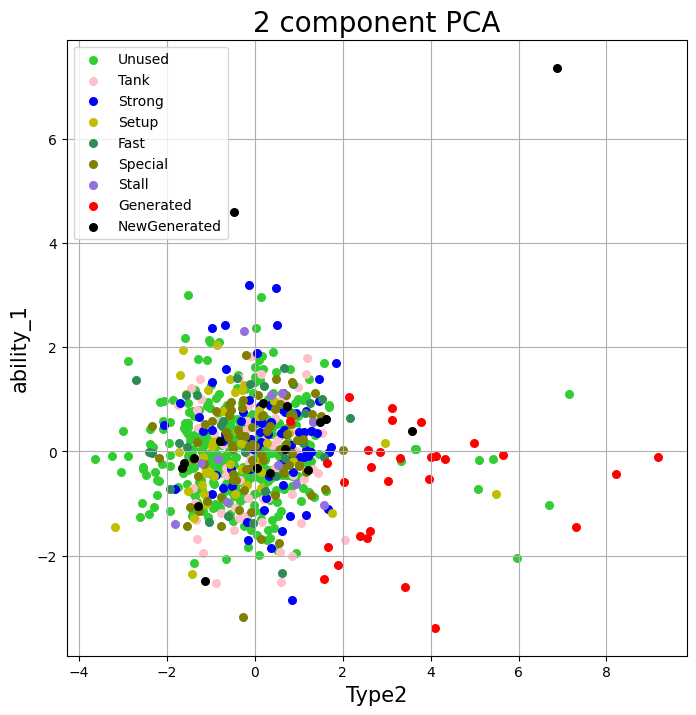

In [32]:
import matplotlib.pyplot as plt
PrincipleComponent1 = 'Type2'
PrincipleComponent2 = 'ability_1'
s = [(2*n)+1 for n in range(len(unique(kf.loc[:, ['Attack']].values)))]
print(s)


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel(PrincipleComponent1, fontsize = 15)
ax.set_ylabel(PrincipleComponent2, fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = unique(kf.loc[:, ['Competitiveness']].values)
colors = ['limegreen', 'pink', 'b','y','seagreen','olive','mediumpurple','red','black','slateblue','darkviolet',
          'plum','navy','wheat','lightblue','orchid','g','firebrick']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Competitiveness'] == target
    ax.scatter(finalDf.loc[indicesToKeep, PrincipleComponent1]
               , finalDf.loc[indicesToKeep, PrincipleComponent2]
               , c = color
               , s = 30)
    #find line of best fit
    

    

    #add line of best fit to plot
     
ax.legend(targets)
a, b = np.polyfit(finalDf.loc[indicesToKeep, PrincipleComponent1], finalDf.loc[indicesToKeep, PrincipleComponent2], 1)
#ax.plot(finalDf.loc[indicesToKeep, PrincipleComponent1], a*finalDf.loc[indicesToKeep, PrincipleComponent1]+b,color="orange") 
ax.grid()